In [5]:
import csv

In [6]:
import pandas as pd

In [7]:
import scipy as sp

In [8]:
import numpy as np

In [9]:
import sklearn

In [10]:
from sklearn import linear_model

In [24]:
import matplotlib.pyplot as plot
regr = linear_model.LinearRegression()

In [25]:
total_mtDNA_base_composition=pd.read_csv("total_mtDNA_base_composition.csv")
x_total=total_mtDNA_base_composition["GC%"]
y_total=total_mtDNA_base_composition["Maximum longevity (yrs)"]

/Users/patrickshaffer/miniconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


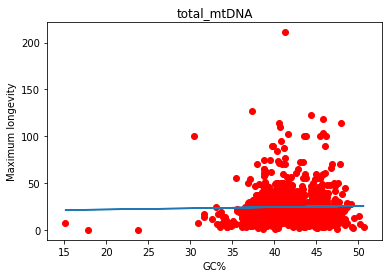

In [26]:
plot_with_linear_coeff(total_mtDNA_base_composition,"total_mtDNA")

This figure shows the maximum longevity of a species vs the GC% in all mitochondrial DNA, along with a linear regression fit in blue, there is a slight positive correlation according to the linear model (which is not a very good model), however, there does seem to be some correlation between longevity and GC%, in what follows I will break this down by protein and see if specific proteins are responsible for this trend

In [16]:
ND3_base_composition= pd.read_csv("ND3_base_composition.csv")

In [17]:
ND3_codon_usage= pd.read_csv("ND3_codon_usage.csv")

In [18]:
data_sets=["ATP6_base_composition","ATP8_base_composition","COX1_base_composition","COX2_base_composition","COX3_base_composition","CYTB_base_composition","ND1_base_composition","ND2_base_composition","ND3_base_composition","ND4_base_composition","ND4L_base_composition","ND5_base_composition","ND6_base_composition"]

In [19]:
all_data= pd.Series([pd.read_csv(data_sets[0]+".csv")], index=[data_sets[0]])

In [20]:
for i in range(1, len(data_sets), 1):
    new_series=pd.Series([pd.read_csv(data_sets[i]+".csv")], index=[data_sets[i]])
    all_data=all_data.append(new_series)

In [27]:
def plot_with_linear_coeff(df, label):
    df = df[df["Maximum longevity (yrs)"] < 400]
    x=df["GC%"]
    y=df["Maximum longevity (yrs)"]
    regr.fit(x.values.reshape(-1,1),y.values.reshape(-1,1))
    plot.xlabel("GC%")
    plot.ylabel("Maximum longevity")
    plot.plot(x.values.reshape(-1,1),regr.predict(x.values.reshape(-1,1)),label="regr.coef_")
    plot.scatter(x,y,color="red")
    plot.title(label)
    plot.show()

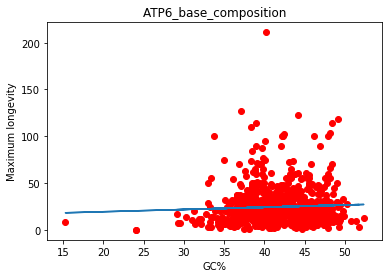

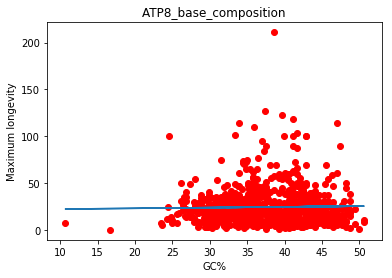

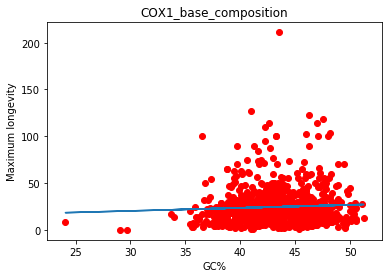

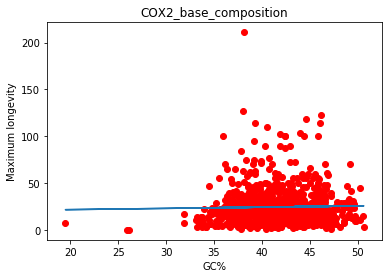

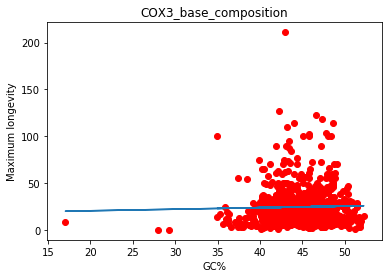

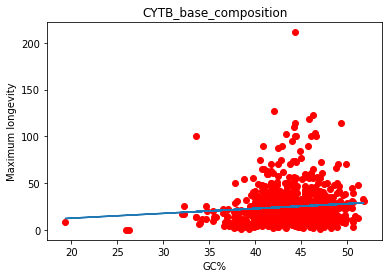

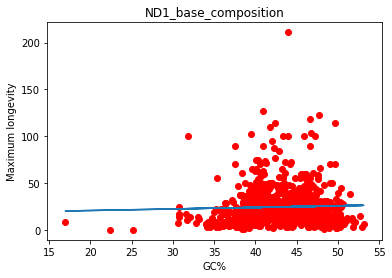

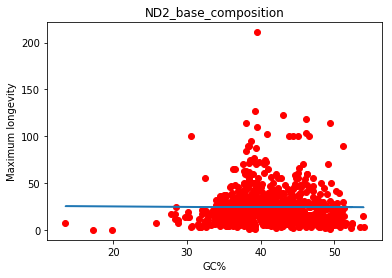

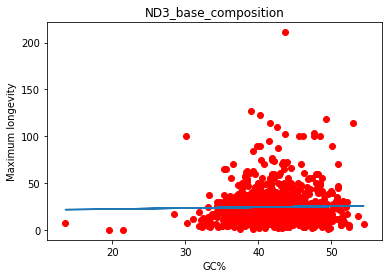

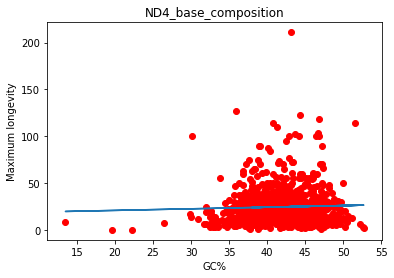

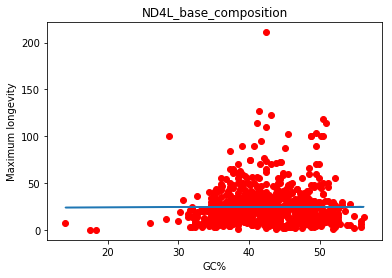

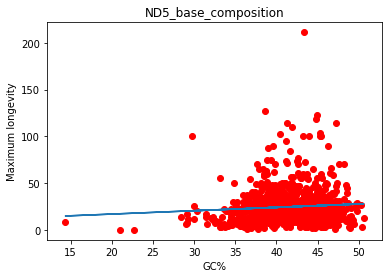

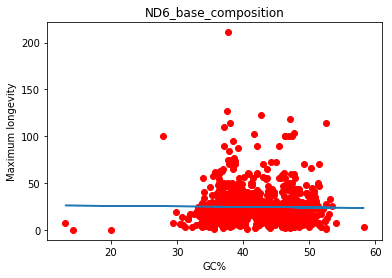

In [28]:
for i in range(len(data_sets)):
    plot_with_linear_coeff(all_data[i],all_data.index[i])

each figure above corresponds to a specific protein that the mtDNA codes for. X-axis is the GC% in the DNA that codes for that protein, and Y-axis is the Maximum longevity of the species. For most proteins there is a slight positive linear correlation. In general the trends for individual proteins looks similar to the trend seen when we look at total mtDNA

In [29]:
q=np.zeros(len(all_data))

In [30]:
def linear_coefficients(A, B):
    X=A.values.reshape(-1,1)
    Y=B.values.reshape(-1,1)
    regr.fit(X,Y)
    return regr.coef_

In [31]:
for i in range(len(all_data)):
    df = all_data[i]
    df = df[df["Maximum longevity (yrs)"] < 400]
    x = df["GC%"]
    y = df["Maximum longevity (yrs)"]
    q[i]=linear_coefficients(x,y)

In [32]:
q

array([ 0.23975334,  0.07748724,  0.32106215,  0.13136583,  0.16520609,
        0.51443551,  0.16608139, -0.02737522,  0.09945568,  0.17145156,
        0.02047652,  0.35895358, -0.05674374])

In [33]:
x=np.arange(len(all_data))

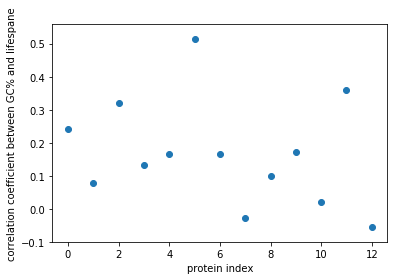

In [34]:
plot.scatter(x,q)
plot.xlabel("protein index")
plot.ylabel("correlation coefficient between GC% and lifespane")
plot.show()

this plot shows that most individual proteins have a postive correlation between GC% and lifespan

In [35]:
total_pc_base_composition=pd.read_csv("total_pc_base_composition.csv")

In [36]:
x1=total_pc_base_composition["GC%"]

In [37]:
y1=total_pc_base_composition["Maximum longevity (yrs)"]

In [38]:
plot.scatter(x1,y1,color="red")
plot.scatter(x_total,y_total,color="blue")
plot.xlabel("GC%")
plot.ylabel("Maximum lifespan")

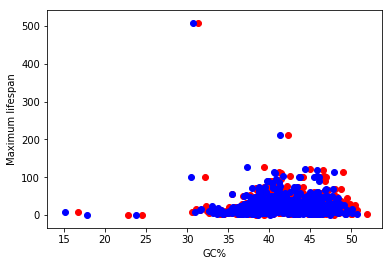

In [39]:
plot.show()

This figure shows the overlay of data from the total mtDNA and the protein coding portion of mtDNA. Patterns are very similar for both. This suggests that the connection between mtDNA base composition and lifespan is not associated with the proteins that are coded for

In [40]:
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo
from Bio.pairwise2 import format_alignment

In [41]:
data_sets_cu=["ATP6_codon_usage","ATP8_codon_usage","COX1_codon_usage","COX2_codon_usage","COX3_codon_usage","CYTB_codon_usage","ND1_codon_usage","ND2_codon_usage","ND3_codon_usage","ND4_codon_usage","ND4L_codon_usage","ND5_codon_usage","ND6_codon_usage"]

These data sets contain the amino acid sequences for each species, and for each protein.

In [42]:
all_data_cu= pd.Series([pd.read_csv(data_sets_cu[0]+".csv")], index=[data_sets_cu[0]])

In [43]:
for i in range(1, len(data_sets_cu), 1):
    new_series=pd.Series([pd.read_csv(data_sets_cu[i]+".csv")], index=[data_sets_cu[i]])
    all_data_cu=all_data_cu.append(new_series)

In [44]:
matrix = MatrixInfo.blosum62

we will use the blosum62 scoring matrix to score amino acid alignments

In [54]:
averages=np.zeros(len(data_sets_cu))

In [46]:
all_data_cu[1].sort_values("Maximum longevity (yrs)")["HAGRID"].head(2)

429      4
67     311
Name: HAGRID, dtype: int64

In [53]:
def compute_average_align_score(prot_df):
    reference = prot_df[prot_df["HAGRID"] == 4]
    sequence_ref = reference["Amino Acids"].values[0].replace('*','')
    average=0
    counter=0
    for i in range (len(prot_df.index)):
        sequence1 = prot_df["Amino Acids"][i].replace('*','')
        alignment = pairwise2.align.globalds(sequence1, sequence_ref, matrix, -10, -0.5)
        average += alignment[0][2]
        counter += 1
    average=average/counter
    return average

In [55]:
for i in range(10):
    averages[i]=compute_average_align_score(all_data_cu[i])

In [56]:
correlations=np.zeros([len(data_sets_cu),len(data_sets_cu)])

In [57]:
averages

array([  354.54402174,    44.96405229,  2126.58913043,   733.81521739,
         988.19749728,  1410.36314068,   747.59565217,   545.2076087 ,
         230.17083787,   936.37758433,     0.        ,     0.        ,
           0.        ])

In [ ]:
def protein_correlations():
    corr_matrix = np.zeros([len(data_sets_cu),len(data_sets_cu)])
    for i in range(10):
        df1=all_data_cu[i]
        ref1=df1[df1["HAGRID"] == 4]
        seq_ref1=ref1["Amino Acids"].values[0].replace('*','')
        for j in range(i+1,10):
            df2=all_data_cu[j]
            ref2=df2[df2["HAGRID"] == 4]
            seq_ref2=ref2["Amino Acids"].values[0].replace('*','')
            counter=0
            for k in range(len(df1.index)):
                seq1=df1["Amino Acids"][k].replace('*','')
                alignment1 = pairwise2.align.globalds(seq1, seq_ref1, matrix, -10, -0.5)
                score1_delta = alignment1[0][2]-averages[i]
                df_spec2=df2[df2["HAGRID"] == df1["HAGRID"][k]]
                if(df_spec2.size>0):
                    seq2=df_spec2["Amino Acids"].values[0].replace('*','')
                    alignment2 = pairwise2.align.globalds(seq2, seq_ref2, matrix, -10, -0.5)
                    score2_delta = alignment2[0][2]-averages[j]
                    corr_matrix[i][j] += score1_delta*score2_delta
                    counter += 1
            corr_matrix[i][j] /= counter
            corr_matrix[i][j] /= len(df1["Amino Acids"][1])*len(df2["Amino Acids"][2])
            print (i,j, corr_matrix[i][j])
    return corr_matrix
                    

In [ ]:
correlations_matrix = protein_correlations()

0 1 0.0168616118549
0 2 0.00641594314481
0 3 0.0107247920541
0 4 0.00826396827276
0 5 0.00774499963449
0 6 0.0145187138092
0 7 0.0169315743102
0 8 0.0146659291085
0 9 0.0152674923744
1 2 0.00458653777766
1 3 0.0293694597088
1 4 0.00978668979626
1 5 0.0192757222151
1 6 0.0077637054766
1 7 0.0147322775334
1 8 0.0284953973092


In [ ]:
correlations_matrix[0][2]